In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
# Read files from each libary
df_acm = pd.read_csv("files/acm.csv")
df_ieee = pd.read_csv("files/ieee.csv")
df_scopus = pd.read_csv("files/scopus.csv")

In [3]:
# Set columns of interest 
selected_columns = ['Authors', 'Title', 'Year', 'DOI', 'Link', 'Abstract', 'Keywords', 'Database', 'Item Type', 'Journal', 'ISSN', 'Volume', 'Issue', 'Pages', 'Publisher', 'Notes', 'Key']

In [4]:
# Renaming ACM columns 
df_acm = df_acm.rename(columns={
    'Author': 'Authors',
    'Publication Year': 'Year',
    'Url': 'Link',
    'Abstract Note': 'Abstract',
    'Manual Tags': 'Keywords',
    'Journal Abbreviation': 'Journal'
})
df_acm["Database"] = "acm"
df_acm = df_acm.loc[:, selected_columns]

In [5]:
# Renaming IEEE columns 
ieee_translation = {
    'Document Title': 'Title', 
    'Publication Year': 'Year', 
    'PDF Link': 'Link',
    'Author Keywords': 'Keywords',
    'Document Identifier': 'Item Type',
}
df_ieee = df_ieee.rename(columns=ieee_translation)
df_ieee["Database"] = "ieee"
df_ieee['Pages'] = df_ieee['End Page'] - df_ieee['Start Page']
df_ieee['Journal'] = None
df_ieee['Notes'] = None
df_ieee['Key'] = None
df_ieee = df_ieee.loc[:, selected_columns]

In [6]:
# Renaming scopus columns 

scopus_translation = {
  'Page count': 'Pages'
}
df_scopus = df_scopus.rename(columns=scopus_translation)

#'Journal', 'Notes', 'Key'
df_scopus['Keywords'] = df_scopus['Author Keywords'] + ';' + df_scopus['Index Keywords']
df_scopus["Database"] = "scopus"
df_scopus['Item Type'] = df_scopus['Document Type']
df_scopus['Key'] = None
df_scopus['Journal'] = None
df_scopus['Notes'] = None
df_scopus = df_scopus.loc[:, selected_columns]

In [7]:
# Join all dfs
df = pd.DataFrame(columns= selected_columns + ['Title Points', 'Abstract Points', 'Keywords Points'])
df_concat = pd.concat([df, df_acm, df_ieee, df_scopus])

In [8]:
# Normalize title
df_concat["title_normalized"] = (
    df_concat['Title']
    .str.strip() 
    .str.replace(r'\s+', ' ', regex=True) 
    .str.lower() 
    .str.replace(r'[^\w\s]', '', regex=True)
)

In [9]:
ethical_terms = {   
  'ethics': 5,
  'ethical': 5,
  'responsibility': 5,
  'responsible': 5,
  'moral': 5,
  'fairness': 2,
  'accountability': 3,
  'accountable': 3,
  'transparent': 2,
  'transparency': 2,
  'bias': 4,
  'trust': 2,
  'liable': 2,
  'liability': 2,

# interesting words to score, but not considered by the search engine

  'explicability': 1,
  'explainability': 1,
  'interpretability': 1,
  'understandability': 1,
  'comprehensibility': 1,
  'perception': 1,
  'uncertainty': 1,
  'understanding': 1
}


viz_term = {
'visualisation': 10,
'visualization': 10,
'visual analytics': 10,

# interesting words to score, but not considered by the search engine
 'infovis': 5,
 'graphical': 5,
 'chart': 5,
 'visualising': 8,
 'visualizing': 8,
 'datavis': 5
}

In [10]:
# Function that normalize a string
def normalize_string(text):
    text = text.strip()
    text = re.sub(r'/s+', ' ', text)
    text = text.replace('-', ' ')
    text = text.lower()
    return text

In [11]:
# Function that calculate points of a text
def calculate_points(value):
   try:
      points = 0
      ethical_list = ethical_terms.keys()
      points_abstract_ethical = 0
      points_abstract_vis = 0

      for term in ethical_list:
         if(term in normalize_string(value)):
            points += ethical_terms[term]
            points_abstract_ethical += 1
      
       
      viz_list = viz_term.keys()
      for term in viz_list:
         if(term in normalize_string(value)):
            points += viz_term[term]
            points_abstract_vis += 1
   except:
      return -1 # colunm value is nan
   return points

In [12]:
df_concat['Title Points'] = df_concat['Title'].apply(lambda x: calculate_points(x))
df_concat['Abstract Points'] = df_concat['Abstract'].apply(lambda x: calculate_points(x))
df_concat['Keywords Points'] = df_concat['Keywords'].apply(lambda x: calculate_points(x))

In [13]:
df = df_concat.copy()
df = df.reset_index()

In [15]:
total_files = df.shape[0]
print("total initial articles", total_files)
print("total initial articles by db")
print(df.groupby("Database").size())
# df[df.duplicated(subset=['Title'], keep=False)][["title_normalized", "Year"]].sort_values("title_normalized")


print("**************************** removing duplicates **********************************")

df.sort_values("Database").drop_duplicates(subset=['title_normalized'])

df = df.sort_values("Database").drop_duplicates(subset=['title_normalized'])
df


print("articles removed", total_files - df.shape[0])
print("total of articles", df.shape[0])
print("total of articles by db:")
print(df.groupby("Database").size())

total initial articles 879
total initial articles by db
Database
acm        99
ieee      101
scopus    679
dtype: int64
**************************** removing duplicates **********************************
articles removed 0
total of articles 879
total of articles by db:
Database
acm        99
ieee      101
scopus    679
dtype: int64


In [16]:
# Analysing colunm pontuation

def describe_colunm(colunm):
    print(colunm)
    print(df[colunm].describe())


describe_colunm('Title Points')
describe_colunm('Abstract Points')
describe_colunm('Keywords Points')

Title Points
count    879.000000
mean       4.813424
std        5.032175
min        0.000000
25%        0.000000
50%        2.000000
75%       10.000000
max       20.000000
Name: Title Points, dtype: float64
Abstract Points
count    879.000000
mean      11.546075
std        6.513337
min       -1.000000
25%        5.000000
50%       12.000000
75%       15.000000
max       34.000000
Name: Abstract Points, dtype: float64
Keywords Points
count    879.000000
mean      12.067122
std        6.384870
min       -1.000000
25%       12.000000
50%       12.000000
75%       15.000000
max       30.000000
Name: Keywords Points, dtype: float64


In [17]:
df["Total Points"] = df["Title Points"] + df["Abstract Points"] + df['Keywords Points']

In [18]:
# Applying E3 - Removing articles < 2014

total_files = df.shape[0]
df = df[df["Year"] >= 2014]
print("filtering by year > 2014")
print("removed", total_files - df.shape[0])
print(df.groupby("Database").size())

filtering by year > 2014
removed 255
Database
acm        78
ieee       80
scopus    466
dtype: int64


In [19]:
# Applying E2 - Removing articles that dont explicitate an ethical aspect i.e. not scored at abstract 

df[df['Abstract Points'] == -1].groupby(["Database", "Item Type"]).size()
df[df['Abstract Points'] == 0].groupby(["Database", "Item Type"]).size()

print(df.shape[0])
print('Removing those that the abstract doesn\'t score')
index_to_drop = df[df['Abstract Points'] < 1].index
print("removed = ", len(index_to_drop))
df = df.drop(index=index_to_drop)
df.shape[0]
df.groupby(["Database"]).size()


624
Removing those that the abstract doesn't score
removed =  25


Database
acm        73
ieee       77
scopus    449
dtype: int64

30.0


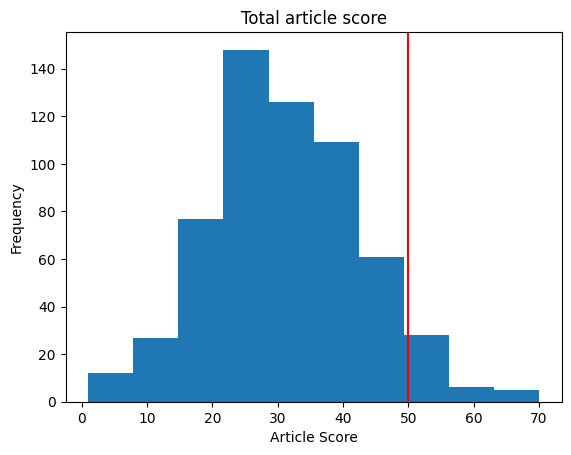

In [25]:
# Prioratizing by score

print(df["Total Points"].median())
df_filter = df[df["Total Points"] >= 50]

plt.hist(x=df["Total Points"], bins=10)

plt.axvline(x=50, color='red', linestyle='-', label='Linha em x=50')

plt.xlabel('Article Score')
plt.ylabel('Frequency')
plt.title('Total article score')

plt.show()

In [27]:
df_to_save = df_filter.drop('index', axis=1)

df_to_save.to_csv('points_50.csv', index=False)  

df_to_save.shape

(39, 22)